# Purpose of This Notebook - Main Analysis

This notebook trains the calibrated four-variable XGBoost model using nested cross-validation.
It generates out-of-fold predictions, risk stratification, Kaplan–Meier analyses, and calibration outputs.
The dataset is not provided in this repository.
Place your local dataset inside the ./data/ directory before running the notebook.

## 1. Environment Setup and Read File

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats
from scipy.special import logit
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, 
    FunctionTransformer, 
    OrdinalEncoder, 
    OneHotEncoder
)
from sklearn.utils import resample
from sklearn.model_selection import (
    StratifiedKFold, 
    RandomizedSearchCV, 
    cross_val_score, 
    cross_val_predict, 
    cross_validate
)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    average_precision_score, 
    brier_score_loss,
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

import joblib
import shap

/Users/huangshifeng/mlenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df=pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_edr/local_data/all_cases_prepared_for_ML.parquet', engine='pyarrow')

## 2. Define Features

In [56]:
features = [
    'AJCC_Substage',   # 3A, 3B, 3C
    'PNI',             # 0/1
    'LNR',             # 0/1
    'Differentiation', # Well/Mod/Poor/Undifferentiated recorded as 1/2/3/4)
]

target_col = 'edr_18m'   # target variable (0/1)
X = df[features].copy()
y = df[target_col].astype(int)

X['PNI'] = X['PNI'].astype(float)
X['Differentiation'] = X['Differentiation'].astype(float)

X = pd.get_dummies(df[features], columns=['AJCC_Substage'])

X.replace([np.inf, -np.inf], np.nan, inplace=True) #Turn infinite numbers to NaN

print(f"Feature Matrix shape: {X.shape}")
print(f"Missing Value Counts (Pre-imputation):\n{X.isnull().sum()[X.isnull().sum()>0]}") 

Feature Matrix shape: (331, 6)
Missing Value Counts (Pre-imputation):
PNI                3
Differentiation    1
dtype: int64


## 3. Build Main Model + Nested CV (5x3)

In [57]:
warnings.filterwarnings("ignore")

# 1. Prepare hyperparameters grid 
param_grid_full = {
    'xgb__n_estimators': [30, 50, 70, 100, 150, 200],
    'xgb__max_depth': [2, 3, 4, 5],
    'xgb__learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'xgb__gamma': [0, 0.1, 0.5, 1],
    'xgb__min_child_weight': [1, 2, 3],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'xgb__reg_alpha': [0, 0.1, 0.5, 1],
    'xgb__reg_lambda': [1, 1.5, 2, 3]
}

# Define baseline Pipeline for hyperparameters searching
ratio = float(y.value_counts()[0] / y.value_counts()[1])
pipeline_base = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=8251,
        scale_pos_weight=ratio,
        n_jobs=1
    ))
])

# Defined inner and outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=8251)

# 2. Manually looping nested CV + calibration (core analysis)
nested_auc_scores = []
best_params_list = []
y_prob_oof = np.zeros(len(y))

# Looping for 5 outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Processing Fold {i+1}/5 ...")
    
    # 1. Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 2. Inner Loop 1: Hyperparameter Tuning
    clf = RandomizedSearchCV(
        estimator=pipeline_base,
        param_distributions=param_grid_full,
        n_iter=5000,
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        random_state=8251,
        verbose=0
    )
    clf.fit(X_train, y_train)
    best_params = clf.best_params_
    best_params_list.append(best_params)
    
    # 3. Inner Loop 2: calibration
    # Use the best parameter to build a new XGB
    best_xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=8251,
        scale_pos_weight=ratio,
        n_jobs=1,
        **{k.replace('xgb__', ''): v for k, v in best_params.items()}
    )

    # Use isotonic calibration
    calibrated_model = CalibratedClassifierCV(best_xgb, method='isotonic', cv=3)
    
    # Final Pipeline (Imputation first then enter to calibration model)
    final_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('model', calibrated_model)
    ])
    
    # 4. Train and predict
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict_proba(X_test)[:, 1] # calibrated probability
    
    # 5. Collect results
    nested_auc_scores.append(roc_auc_score(y_test, y_pred))
    y_prob_oof[test_idx] = y_pred

y_prob_calib_cv = y_prob_oof

# 3. Results output
print(f"Mean AUC: {np.mean(nested_auc_scores):.3f}")
print(f"95% CI: {np.mean(nested_auc_scores) - 2*np.std(nested_auc_scores):.4f} - {np.mean(nested_auc_scores) + 2*np.std(nested_auc_scores):.4f}")
print(f"AUC in each fold: {nested_auc_scores}")
print("Best parameters in each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")



Processing Fold 1/5 ...
Processing Fold 2/5 ...
Processing Fold 3/5 ...
Processing Fold 4/5 ...
Processing Fold 5/5 ...
Mean AUC: 0.706
95% CI: 0.5529 - 0.8601
AUC in each fold: [0.5826210826210826, 0.7847222222222222, 0.7816358024691358, 0.6604938271604939, 0.7227866473149492]
Best parameters in each fold:
Fold 1: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 3, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.02, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.5}
Fold 2: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 1.5, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 50, 'xgb__min_child_weight': 2, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.5}
Fold 3: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 2, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 30, 'xgb__min_child_weight': 2, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.5}
Fold 4: {'x

## 4. Build Conventional Logistic Model Using Only AJCC Substaging
As a comparator to our main model

In [73]:
warnings.filterwarnings("ignore")

# 1. AJCC_Substage: Define feature variables
features_ajcc = [col for col in X.columns if 'AJCC' in col]
X_ajcc = X[features_ajcc]
y = df['edr_18m'].astype(int)

# 2. Conventional Logistic Regression
# C=1e9 -> minimal regularization to simulate conventional statistical methods; 
# class_weight='balanced' addresses data imbalance
lr = LogisticRegression(C=1e9, class_weight='balanced', solver='liblinear', random_state=8251)

# 3. 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
ajcc_scores = cross_val_score(lr, X_ajcc, y, cv=cv, scoring='roc_auc')

# 4. Use cross_val_predict to obtain OOF (Out-of-Fold) predicted probabilities
y_prob_ajcc_cv = cross_val_predict(lr, X_ajcc, y, cv=cv, method='predict_proba')[:, 1]

# 5. Calculate ROC Curve and identify Youden's Index (J = Sensitivity + Specificity - 1)
fpr, tpr, thresholds = roc_curve(y, y_prob_ajcc_cv)
J = tpr - fpr
ix = np.argmax(J)
best_cutoff = thresholds[ix]

# 6. Generate binary classification results based on the optimal cutoff
y_true_arr = y.to_numpy()
y_prob_arr = y_prob_ajcc_cv
y_pred_optimal = (y_prob_arr >= best_cutoff).astype(int)

# 7. Calculate Confusion Matrix and performance metrics (point estimates)
tn, fp, fn, tp = confusion_matrix(y_true_arr, y_pred_optimal).ravel()

sen_pt = tp / (tp + fn) if (tp + fn) > 0 else 0
spec_pt = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv_pt = tp / (tp + fp) if (tp + fp) > 0 else 0
npv_pt = tn / (tn + fn) if (tn + fn) > 0 else 0

# AUC point estimate (using full OOF probabilities)
auc_pt = roc_auc_score(y_true_arr, y_prob_arr)

# ========= Bootstrap (n_boots=1000) for 95% CI =========
n_boots = 1000
random_seed = 8251
np.random.seed(random_seed)

def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    return sen, spec, ppv, npv

boot_results = {
    'AUC': [],
    'Sen': [],
    'Spec': [],
    'PPV': [],
    'NPV': []
}

for _ in range(n_boots):
    idx = np.random.choice(len(y_true_arr), len(y_true_arr), replace=True)
    y_true_boot = y_true_arr[idx]
    y_prob_boot = y_prob_arr[idx]

    # AUC: Ensure both classes are present in the bootstrap sample
    if len(np.unique(y_true_boot)) == 2:
        auc_b = roc_auc_score(y_true_boot, y_prob_boot)
        boot_results['AUC'].append(auc_b)

    s, sp, p, n = calculate_metrics(y_true_boot, y_prob_boot, best_cutoff)
    boot_results['Sen'].append(s)
    boot_results['Spec'].append(sp)
    boot_results['PPV'].append(p)
    boot_results['NPV'].append(n)

# 8. Output results
print(f"AJCC (LR) Mean AUC (5-fold CV): {ajcc_scores.mean():.3f}")
print(f"Optimal Cutoff (Youden)      : {best_cutoff:.4f}")

# AUC CI
auc_lower = np.percentile(boot_results['AUC'], 2.5)
auc_upper = np.percentile(boot_results['AUC'], 97.5)
print(f"AUC (OOF)                    : {auc_pt:.3f} [{auc_lower:.3f} - {auc_upper:.3f}]")

metrics_map = {
    'Sensitivity': (sen_pt, boot_results['Sen']),
    'Specificity': (spec_pt, boot_results['Spec']),
    'PPV        ': (ppv_pt, boot_results['PPV']),
    'NPV        ': (npv_pt, boot_results['NPV'])
}

for name, (pt, boots) in metrics_map.items():
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    print(f"{name}                : {pt:.3f} [{lower:.3f} - {upper:.3f}]")

AJCC (LR) Mean AUC (5-fold CV): 0.688
Optimal Cutoff (Youden)      : 0.7150
AUC (OOF)                    : 0.625 [0.545 - 0.698]
Sensitivity                : 0.452 [0.329 - 0.578]
Specificity                : 0.855 [0.812 - 0.896]
PPV                        : 0.418 [0.302 - 0.538]
NPV                        : 0.871 [0.830 - 0.908]


### 4.1 Figure 2 ROC/Calibration/DCA Curves

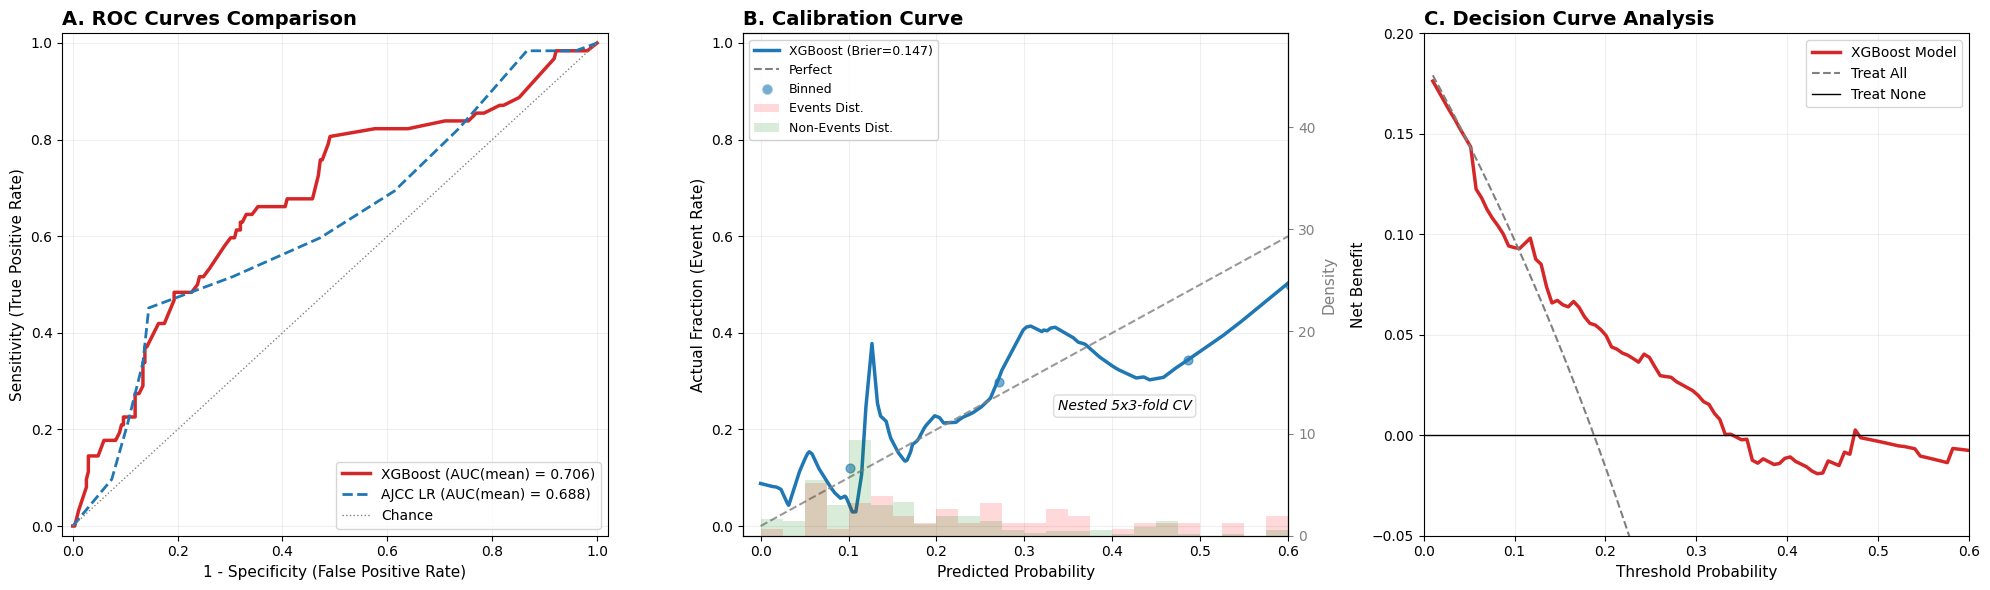

In [59]:
# Execute previous cells to get X_ajcc, lr, cv, y_prob_calib_cv, y_prob_ajcc_cv

# Get predictions of probability from AJCC
auc_ajcc = roc_auc_score(y, y_prob_ajcc_cv)
auc_xgb = roc_auc_score(y, y_prob_calib_cv)

# 1. Set figure (1 Row, 3 Columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.3) 


# Panel A: ROC Curves Comparison
ax1 = axes[0]

# Calculate ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y, y_prob_calib_cv)
fpr_ajcc, tpr_ajcc, _ = roc_curve(y, y_prob_ajcc_cv)

# Plot
ax1.plot(fpr_xgb, tpr_xgb, color='#d62728', lw=2.5, label=f'XGBoost (AUC(mean) = {np.mean(nested_auc_scores):.3f})')
ax1.plot(fpr_ajcc, tpr_ajcc, color='#1f77b4', lw=2, linestyle='--', label=f'AJCC LR (AUC(mean) = {ajcc_scores.mean():.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Chance')

# Set parameters of display
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])
ax1.set_xlabel('1 - Specificity (False Positive Rate)', fontsize=11)
ax1.set_ylabel('Sensitivity (True Positive Rate)', fontsize=11)
ax1.set_title('A. ROC Curves Comparison', fontsize=14, fontweight='bold', loc='left')
ax1.legend(loc="lower right", fontsize=10, frameon=True)
ax1.grid(True, alpha=0.2)

# Panel B: Calibration Curve
ax2 = axes[1]

# Calculations
brier = brier_score_loss(y, y_prob_calib_cv)
lowess_results = lowess(y, y_prob_calib_cv, frac=0.2, it=0)
x_smooth = lowess_results[:, 0]
y_smooth = lowess_results[:, 1]
prob_true_bin, prob_pred_bin = calibration_curve(y, y_prob_calib_cv, n_bins=5)

# Left axis: calibration curve
line1, = ax2.plot(x_smooth, y_smooth, color='#1f77b4', lw=2.5, label=f'XGBoost (Lowess)')
line2, = ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8, label='Perfectly Calibrated')
scatter = ax2.scatter(prob_pred_bin, prob_true_bin, color='#1f77b4', s=40, alpha=0.6, label='Binned (n=5)', zorder=5)

ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Actual Fraction (Event Rate)', fontsize=11)
ax2.set_ylim([-0.02, 1.02])
ax2.set_xlim([-0.02, 0.6])
ax2.set_title('B. Calibration Curve', fontsize=14, fontweight='bold', loc='left')
ax2.grid(True, alpha=0.2)

# Right axis: histogram
ax2_twin = ax2.twinx()
ax2_twin.hist(y_prob_calib_cv[y==1], bins=40, range=(0,1), density=True, color='red', alpha=0.15, label='Events')
ax2_twin.hist(y_prob_calib_cv[y==0], bins=40, range=(0,1), density=True, color='green', alpha=0.15, label='Non-Events')
ax2_twin.set_ylim(0, ax2_twin.get_ylim()[1] * 5)
ax2_twin.set_ylabel('Density', fontsize=11, color='gray')
ax2_twin.tick_params(axis='y', colors='gray')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=2.5, label=f'XGBoost (Brier={brier:.3f})'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='--', label='Perfect'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=8, alpha=0.6, label='Binned'),
    plt.Rectangle((0,0),1,1, fc="red", alpha=0.15, label='Events Dist.'),
    plt.Rectangle((0,0),1,1, fc="green", alpha=0.15, label='Non-Events Dist.')
]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9)

# Annotation
ax2.text(0.7, 0.25, "Nested 5x3-fold CV", transform=ax2.transAxes, fontsize=10, ha='center', style='italic', bbox=dict(facecolor='white', alpha=0.7, edgecolor='#cccccc', boxstyle='round'))

# Panel C: Decision Curve Analysis (DCA)
ax3 = axes[2]

# DCA calculation
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    for pt in thresholds:
        y_pred = y_prob >= pt
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(net_benefit)
    return np.array(net_benefits)

thresholds = np.linspace(0.01, 0.6, 100)
nb_model = calculate_net_benefit(y, y_prob_calib_cv, thresholds)
prevalence = np.mean(y)
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))

ax3.plot(thresholds, nb_model, color='#d62728', lw=2.5, label='XGBoost Model')
ax3.plot(thresholds, nb_all, color='gray', linestyle='--', lw=1.5, label='Treat All')
ax3.axhline(y=0, color='black', linestyle='-', lw=1, label='Treat None')

ax3.set_xlim([0, 0.6])
ax3.set_ylim([-0.05, 0.2])
ax3.set_xlabel('Threshold Probability', fontsize=11)
ax3.set_ylabel('Net Benefit', fontsize=11)
ax3.set_title('C. Decision Curve Analysis', fontsize=14, fontweight='bold', loc='left')
ax3.legend(loc='upper right', fontsize=10, frameon=True)
ax3.grid(True, alpha=0.2)

# 4. Output
# ==========================================
plt.tight_layout()
plt.savefig('Figure_2_Model_Performance.tiff', dpi=600, bbox_inches='tight')
plt.savefig('Figure_2_Model_Performance.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.2 Table 2: Comparison of predictive performance of AJCC only and XGBoost model
The cutoff value was derived from the OOF Youden index and was not based on whole derivation cohort.

In [76]:
# --- DeLong Test Helper Functions ---
def compute_midrank(x):
    """Computes midranks for DeLong test."""
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    T2[J] = T + 1
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    """Fast DeLong algorithm implementation."""
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)

    # Split sorted predictions into positive and negative examples
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]

    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])

    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n

    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m

    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n

    return aucs, delongcov

def calc_pvalue(aucs, sigma):
    """Calculates p-value from Z-score."""
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    # Two-tailed test
    return 2 * scipy.stats.norm.sf(np.abs(z))

def get_delong_pvalue(y_true, y_pred1, y_pred2):
    """
    Computes DeLong's test p-value for two correlated ROC curves.
    
    Args:
        y_true: True binary labels
        y_pred1: Probabilities from Model 1
        y_pred2: Probabilities from Model 2
    """
    y_true = np.array(y_true).reshape(-1)
    y_pred1 = np.array(y_pred1).reshape(-1)
    y_pred2 = np.array(y_pred2).reshape(-1)

    # Sort based on y_true (descending) to align with Fast DeLong requirements
    order = np.argsort(y_true)[::-1]
    y_true = y_true[order]
    y_pred1 = y_pred1[order]
    y_pred2 = y_pred2[order]

    label_1_count = int(np.sum(y_true))
    
    # Check if we have positive samples
    if label_1_count == 0 or label_1_count == len(y_true):
        return np.nan

    predictions_sorted_transposed = np.vstack((y_pred1, y_pred2))
    
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    p_value = calc_pvalue(aucs, delongcov)
    
    return p_value.item() # Return as float
# -------------------------------------

def get_metrics_and_cutoff(y_true, y_prob):
    # 1. Calculate Youden Cutoff based on current data
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr + (1 - fpr) - 1   # = tpr - fpr
    best_idx = np.argmax(j_scores)
    cutoff_cv = thresholds[best_idx]
    
    # 2. Calculate AUC
    auc = roc_auc_score(y_true, y_prob)
    
    # 3. Classifying based on cutoff
    y_pred = (y_prob >= cutoff_cv).astype(int)
    
    # 4. Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return {
        "AUC": auc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Cutoff": cutoff_cv  # Cutoff specified for this cohort
    }

# Bootstrap 1000 times to calculate confidence interval
def get_ci(y_true, y_prob, metric_name, n_boot=1000):
    values = []
    for i in range(n_boot):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=i)
        y_boot_true = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_boot_prob = y_prob[indices]
        
        try:
            # Re-calculate cutoff and metrics during every bootstrap resampling
            m = get_metrics_and_cutoff(y_boot_true, y_boot_prob)
            values.append(m[metric_name])
        except Exception:
            continue
            
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)
    return lower, upper

# Output: Table 2
models = {
    "AJCC Staging": y_prob_ajcc_cv,
    "XGBoost Model": y_prob_calib_cv
}

results = []

print(f"{'Model':<15} | {'Cutoff':<8} | {'AUC (95% CI)':<25} | {'Sens (95% CI)':<25} | {'Spec (95% CI)':<25} | {'PPV (95% CI)':<25} | {'NPV (95% CI)':<25}")
print("-" * 80)

for name, probs in models.items():
    # Point Estimate
    m = get_metrics_and_cutoff(y, probs)
    
    # CI for all metrics
    auc_lo, auc_hi    = get_ci(y, probs, "AUC")
    sens_lo, sens_hi = get_ci(y, probs, "Sensitivity")
    spec_lo, spec_hi = get_ci(y, probs, "Specificity")
    ppv_lo, ppv_hi    = get_ci(y, probs, "PPV")
    npv_lo, npv_hi    = get_ci(y, probs, "NPV")
    
    # formatted output
    cutoff_str = f"{m['Cutoff']:.3f}"
    auc_str    = f"{m['AUC']:.3f} ({auc_lo:.3f}-{auc_hi:.3f})"
    sens_str   = f"{m['Sensitivity']:.1%} ({sens_lo:.2%}-{sens_hi:.2%})"
    spec_str   = f"{m['Specificity']:.1%} ({spec_lo:.2%}-{spec_hi:.2%})"
    ppv_str    = f"{m['PPV']:.1%} ({ppv_lo:.2%}-{ppv_hi:.2%})"
    npv_str    = f"{m['NPV']:.1%} ({npv_lo:.2%}-{npv_hi:.2%})"
    
    print(f"{name:<15} | {cutoff_str:<8} | {auc_str:<25} | {sens_str:<25} | {spec_str:<25} | {ppv_str:<25} | {npv_str:<25}")

    results.append({
        "Model": name,
        "Cutoff": m['Cutoff'],
        "AUC (95% CI)": auc_str,
        "Sensitivity (95% CI)": sens_str,
        "Specificity (95% CI)": spec_str,
        "PPV (95% CI)": ppv_str,
        "NPV (95% CI)": npv_str
    })

cutoff_cv = m['Cutoff']
print("-" * 160)

df_table2 = pd.DataFrame(results)
cols_to_export = [
    'Model',
    'Cutoff',
    'AUC (95% CI)',
    'Sensitivity (95% CI)',
    'Specificity (95% CI)',
    'PPV (95% CI)',
    'NPV (95% CI)'
]
df_export = df_table2[cols_to_export]

# df_export.to_csv("table2_results.csv", index=False)

# --- DeLong Test Calculation ---
print("DeLong Test for AUC Difference (AJCC vs. XGBoost)")

# Extract predicted probabilities from both models
# Note: Assumes variable names are 'y_prob_ajcc_cv' and 'y_prob_calib_cv',
# and 'y' contains the ground truth labels.
try:
    p_val = get_delong_pvalue(y, y_prob_ajcc_cv, y_prob_calib_cv)
    
    # Calculate AUC values to quantify the difference
    auc_ajcc = roc_auc_score(y, y_prob_ajcc_cv)
    auc_xgb = roc_auc_score(y, y_prob_calib_cv)
    diff = auc_xgb - auc_ajcc
    
    print(f"AUC Difference (XGBoost - AJCC): {diff:+.4f}")
    
    # Format P-value output
    if p_val < 0.001:
        p_str = "< 0.001"
    else:
        p_str = f"{p_val:.4f}"
        
    print(f"P-value: {p_str}")
    
    # Determine statistical significance
    if p_val < 0.05:
        print(">> Result: Statistically Significant Difference")
    else:
        print(">> Result: No Statistically Significant Difference")
        
except Exception as e:
    print(f"Could not calculate DeLong p-value: {e}")


Model           | Cutoff   | AUC (95% CI)              | Sens (95% CI)             | Spec (95% CI)             | PPV (95% CI)              | NPV (95% CI)             
--------------------------------------------------------------------------------
AJCC Staging    | 0.715    | 0.625 (0.543-0.704)       | 45.2% (32.81%-58.34%)     | 85.5% (80.60%-89.51%)     | 41.8% (30.00%-53.12%)     | 87.1% (83.33%-90.91%)    
XGBoost Model   | 0.120    | 0.674 (0.588-0.752)       | 80.6% (45.60%-89.06%)     | 50.9% (46.86%-85.34%)     | 27.5% (23.35%-45.35%)     | 91.9% (85.79%-95.78%)    
----------------------------------------------------------------------------------------------------------------------------------------------------------------
DeLong Test for AUC Difference (AJCC vs. XGBoost)
AUC Difference (XGBoost - AJCC): +0.0492
P-value: 0.0813
>> Result: No Statistically Significant Difference


### 4.3 Sensitivity Test: 4-Featured Penalized Logistic Regression

In [61]:

# Build a four-featured logistic regression pipeline
logit_four = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("logit", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced",
        random_state=8251,
    )),
])

def get_oof_auc(model, X, y, cv_outer):
    """
    Using CV OOF predictions to calculate OOF AUC
    """
    oof_pred = np.zeros_like(y, dtype=float)

    for fold, (train_idx, test_idx) in enumerate(cv_outer.split(X, y), 1):
        m = clone(model)
        m.fit(X.iloc[train_idx], y.iloc[train_idx])
        proba = m.predict_proba(X.iloc[test_idx])[:, 1]
        oof_pred[test_idx] = proba

    auc = roc_auc_score(y, oof_pred)
    return auc, oof_pred


auc_xgb_4, oof_xgb_4 = get_oof_auc(final_pipeline, X, y, outer_cv)
print(f"XGBoost (4 vars)  OOF AUC = {auc_xgb_4:.3f}")

auc_logit_4, oof_logit_4 = get_oof_auc(logit_four, X, y, outer_cv)
print(f"Logistic (4 vars) OOF AUC = {auc_logit_4:.3f}")


XGBoost (4 vars)  OOF AUC = 0.677
Logistic (4 vars) OOF AUC = 0.634


## 5. Cross-Validated KM Analysis of DFS Using XGBoost Model
Figure 3. KM Analysis, risk stratified by main model

Sample size for plotting(n): 329
Total cases for DFS KM analysis: 329
Total DFS events counts: 130


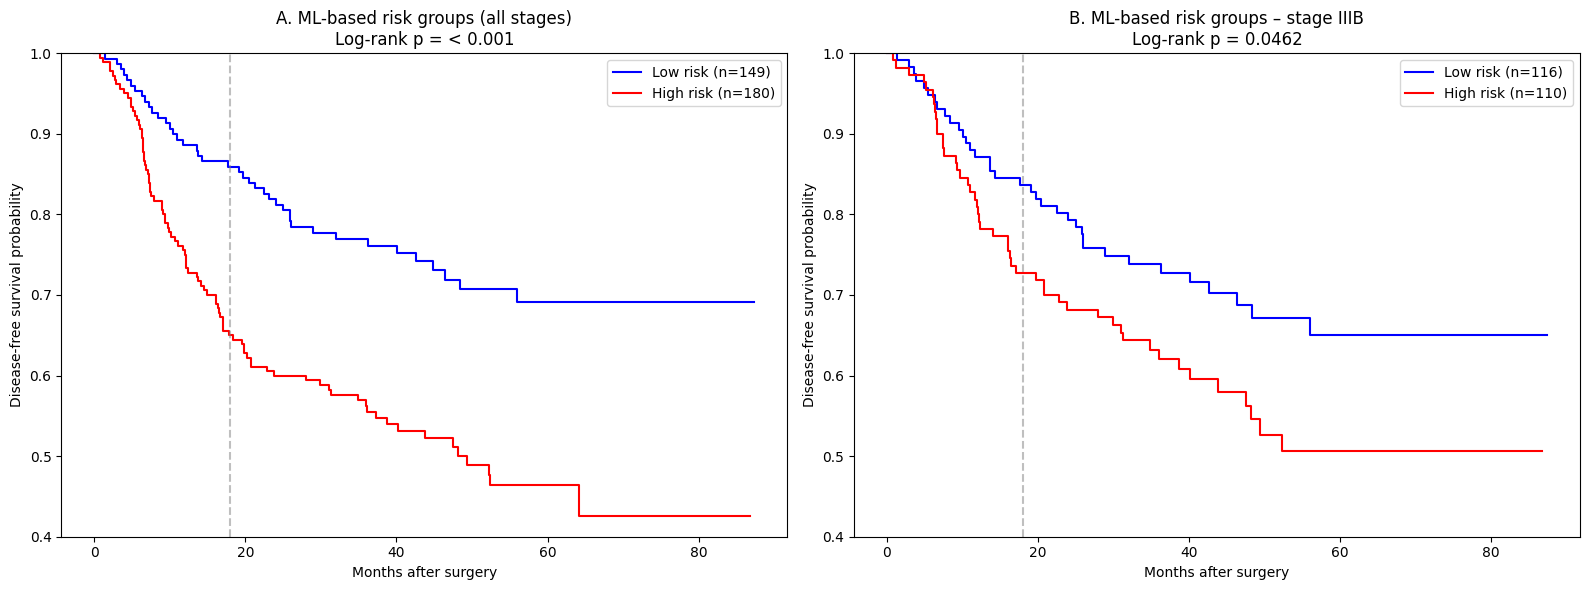

Figure 3A log-rank p (all stages):  < 0.001
Figure 3B log-rank p (stage IIIB): 0.0462


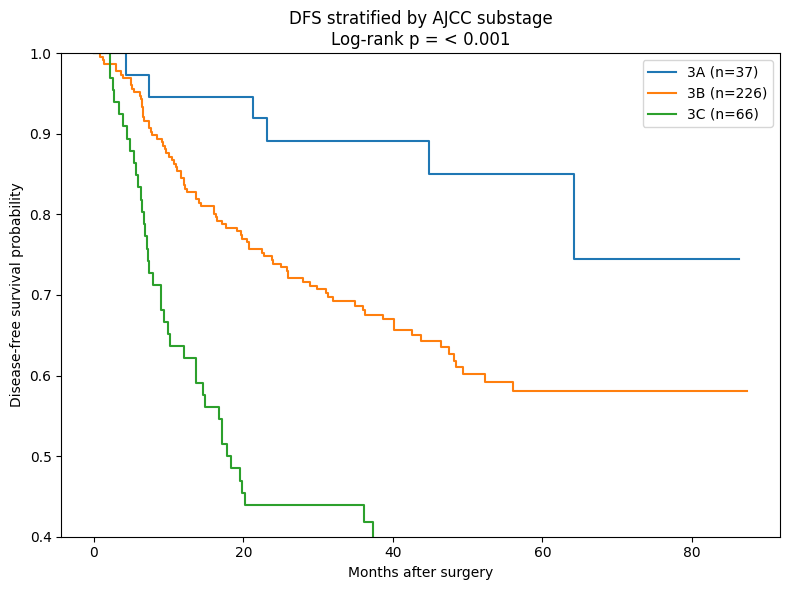

AJCC DFS log-rank p (Figure S2): < 0.001


In [62]:
def format_p(p):
    if p < 0.001:
        return "< 0.001"
    else:
        return f"{p:.4f}"
        
if 'y_prob_calib_cv' not in locals():
    raise ValueError("can not find y_prob_calib_cv，please confirm step 3 (nested CV) is completed")
features = ['AJCC_Substage', 'PNI', 'LNR', 'Differentiation']
cols_needed = features + ['edr_18m', 'DFS_Months', 'Recurrence', 'Death']
df_clean = df[cols_needed].copy()
df_train = df_clean.dropna(subset=['edr_18m']).copy()

df_train['ML_Prob'] = y_prob_calib_cv
df_plot = df_train.dropna(subset=['DFS_Months', 'Recurrence']).copy()

print(f"Sample size for plotting(n): {len(df_plot)}")
# Define DFS Event：recurrence (local or distant) or death (of any cause)
df_plot['DFS_Event'] = (df_plot['Recurrence'] == 1) | (df_plot['Death'] == 1)
df_plot['DFS_Event'] = df_plot['DFS_Event'].astype(int)

# Remove time/event missing values
df_plot.dropna(subset=['DFS_Months', 'DFS_Event'], inplace=True)

print(f"Total cases for DFS KM analysis: {len(df_plot)}")
print(f"Total DFS events counts: {df_plot['DFS_Event'].sum()}")

T = df_plot['DFS_Months']
E = df_plot['DFS_Event']

# Figure 3：ML risk–stratified DFS（Panel A + Panel B）

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kmf = KaplanMeierFitter()

# Panel A：All stages，ML-risk-stratified
ax = axes[0]

high_risk = df_plot['ML_Prob'] >= cutoff_cv #pre-specified in nested CV
low_risk  = df_plot['ML_Prob'] < cutoff_cv

# Low risk
kmf.fit(T[low_risk], E[low_risk],
        label=f"Low risk (n={low_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk
kmf.fit(T[high_risk], E[high_risk],
        label=f"High risk (n={high_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_all = logrank_test(T[low_risk], T[high_risk],
                      E[low_risk], E[high_risk])

ax.set_title(f"A. ML-based risk groups (all stages)\n"
             f"Log-rank p = {format_p(lr_all.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

# Panel B：Stage IIIB，ML-risk-stratified
ax = axes[1]

subgroup_mask = df_plot['AJCC_Substage'].astype(str).str.contains('B')
df_subgroup = df_plot[subgroup_mask].copy()

high_risk_sub = df_subgroup['ML_Prob'] >= cutoff_cv
low_risk_sub  = df_subgroup['ML_Prob'] < cutoff_cv

# Low risk (IIIB)
kmf.fit(df_subgroup.loc[low_risk_sub, 'DFS_Months'],
        df_subgroup.loc[low_risk_sub, 'DFS_Event'],
        label=f"Low risk (n={low_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk (IIIB)
kmf.fit(df_subgroup.loc[high_risk_sub, 'DFS_Months'],
        df_subgroup.loc[high_risk_sub, 'DFS_Event'],
        label=f"High risk (n={high_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_sub = logrank_test(
    df_subgroup.loc[low_risk_sub,  'DFS_Months'],
    df_subgroup.loc[high_risk_sub, 'DFS_Months'],
    df_subgroup.loc[low_risk_sub,  'DFS_Event'],
    df_subgroup.loc[high_risk_sub, 'DFS_Event']
)

ax.set_title(f"B. ML-based risk groups – stage IIIB\n"
             f"Log-rank p = {format_p(lr_sub.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
plt.savefig("Figure3_ML_risk_DFS.tiff", dpi=600, format='tiff')
plt.savefig("Figure3_ML_risk_DFS.png", dpi=600, format='tiff')
plt.show()

print(f"Figure 3A log-rank p (all stages):  {format_p(lr_all.p_value)}")
print(f"Figure 3B log-rank p (stage IIIB): {format_p(lr_sub.p_value)}")

#Figure S2: AJCC KM DFS

fig, ax = plt.subplots(figsize=(8, 6))
for group in sorted(df_plot['AJCC_Substage'].dropna().unique()):
    mask = df_plot['AJCC_Substage'] == group
    if mask.sum() > 0:
        kmf.fit(T[mask], E[mask], label=f"{group} (n={mask.sum()})")
        kmf.plot_survival_function(ax=ax, ci_show=False)

results_ajcc = multivariate_logrank_test(T,
                                         df_plot['AJCC_Substage'],
                                         E)

ax.set_title(f"DFS stratified by AJCC substage\n"
             f"Log-rank p = {format_p(results_ajcc.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
plt.savefig("Figure_S2_AJCC_DFS.tiff", dpi=600, format='tiff')
plt.savefig("Figure_S2_AJCC_DFS.png", dpi=300)
plt.show()

print(f"AJCC DFS log-rank p (Figure S2): {format_p(results_ajcc.p_value)}")

## 6. Build Final Model for Web-based Tool

In [63]:
def format_p(p):
    if p < 0.001:
        return "< 0.001"
    else:
        return f"{p:.4f}"

# 1. Prepare whole cohort
features = ['AJCC_Substage', 'PNI', 'LNR', 'Differentiation']
cols_needed = features + ['edr_18m', 'DFS_Months', 'Recurrence', 'Death']
df_clean = df[cols_needed].copy()
df_train = df_clean.dropna(subset=['edr_18m']).copy()

X = df_train[features].copy()
y = df_train['edr_18m'].astype(int)

print(f"Training cohort sample size: {len(X)}")

# Preprocessing
# 1. To numeric
X['PNI'] = pd.to_numeric(X['PNI'], errors='coerce')
X['Differentiation'] = pd.to_numeric(X['Differentiation'], errors='coerce')

# 2. One-Hot Encoding
X = pd.get_dummies(X, columns=['AJCC_Substage'])

X.replace([np.inf, -np.inf], np.nan, inplace=True)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'final_feature_columns.pkl')
print("Feature columns saved")

# 2. Build and train pipeline
ratio = float(y.value_counts()[0] / y.value_counts()[1])

# (A) Define baseline XGBoost 
xgb_base = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.01,
    min_child_weight=2,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.5,
    reg_lambda=1.5,
    reg_alpha=0,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=8251,
    n_jobs=-1
)


# (B) 5-fold CV
calibrated_clf = CalibratedClassifierCV(xgb_base, method='isotonic', cv=5)

# (C) Build Pipeline (Imputer -> Calibration)
final_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),  # Step1: imputer
    ('model', calibrated_clf)                # Step2: calibrated model
])

# Fit(X, y)
final_pipeline.fit(X, y)

fitted_imputer = final_pipeline.named_steps['imputer']
joblib.dump(fitted_imputer, 'final_knn_imputer.pkl')
print("KNNImputer saved -> final_knn_imputer.pkl")

# (D) Predict
y_pred_prob = final_pipeline.predict_proba(X)[:, 1]
df_train['ML_Prob'] = y_pred_prob

# (E) Save Pipeline (For the Web-based App)
joblib.dump(final_pipeline, 'final_model_calibrated.pkl')
print("Pipeline including imputer saved -> 'final_model_calibrated.pkl'")


# 3. Re-calculate cutoff (if needed)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
j_scores = tpr + (1 - fpr) - 1
best_idx = np.argmax(j_scores)
best_cutoff = thresholds[best_idx]
print(f"Best Cutoff (Youden): {best_cutoff:.4f}")

Training cohort sample size: 331
Feature columns saved
KNNImputer saved -> final_knn_imputer.pkl
Pipeline including imputer saved -> 'final_model_calibrated.pkl'
Best Cutoff (Youden): 0.1438


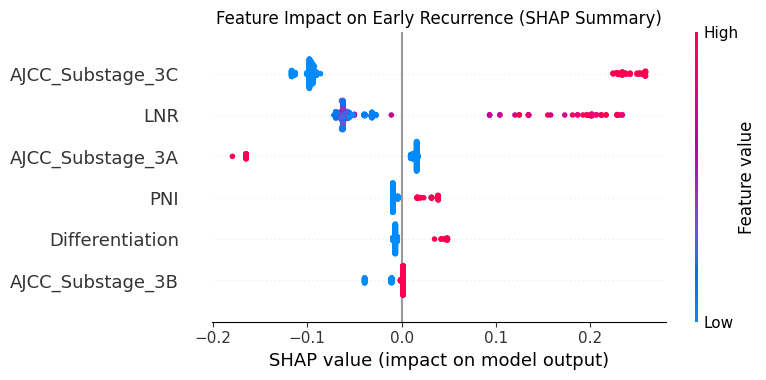

In [64]:
imputer = fitted_imputer # from step 6
X_imputed_array = imputer.transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns)

xgb_base.fit(X_imputed, y)

# Calculate SHAP
explainer = shap.TreeExplainer(xgb_base)
shap_values = explainer.shap_values(X_imputed)

# Plotting
plt.figure(figsize=(10, 8))
plt.title("Feature Impact on Early Recurrence (SHAP Summary)")
shap.summary_plot(shap_values, X_imputed, show=False)
plt.tight_layout()
plt.savefig('Figure_4_SHAP_Plot_XGB.tiff', format='tiff', dpi=600)
plt.savefig('Figure_4_SHAP_Plot_XGB.png', dpi=300)
plt.show()